# Quasar light curve as a stochastic process (Damped Random Walk)
Using the Kelly et al. 2009 article *Are the variations in quasar optical flux driven by thermal fluctuations?* as a basis.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_theme()

Below, I've simply used equation (1) from Kelly et al. (2009):
$\begin{equation}
    dX(t) = -\frac{1}{\tau}X(t)dt + \sigma\sqrt{dt}\:\epsilon(t) + b\: dt
\end{equation}$
Where $\tau$ is the relaxation time or characteristic time, $\sigma$ is the variance, $\epsilon$ is a random white-noise process, described as gaussian with a mean of 0 and variance of 1, so I've chosen to use `np.random.normal(0, 1)` in its stead, and $b$ is the mean of the random walk, the value it should move towards as $t\rightarrow\infty$.

In [86]:
# defining the step dX(t):
def drw_step(t, tau, sigma, b, x0=0.):
    """Damped Random Walk Step

    Args:
        t (array): the time series
        tau (float): relaxation time / characteristic time scale, origin in characteristic timescales for quasars
        sigma (float): variance
        b (float): mean? unsure atm
        x0 (float): starting value
    
    Returns:
        x (array): Damped Random Walk
    """
    
    x = np.zeros_like(t) # make an array of length len(t)
    x[0] = x0
    dt = np.diff(t)
    
    # version 1: is not affected siginificantly by tau
    # for i in range(1, len(t)):
    #     x[i] = - tau**-1 * x[i-1] + sigma*np.sqrt(dt[i-1]) * np.random.normal(0, 1) + b*dt[i-1]
    
    # version 2: I had forgotten the dt in the first term - this overflows rapidly
    # for i in range(1, len(t)):
    #     x[i] = (-x[i-1]/tau) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal(0, 1) + b * dt[i-1]
    
    # version 3: adding exponential terms all over to make it less prone to overflow
    for i in range(1, len(t)):
        exp_term = np.exp(-dt[i-1] / tau)
        x[i] = x[i-1] * exp_term + sigma * np.sqrt(dt[i-1]) * np.random.normal(0, 1) + b * (1 - exp_term)
    
    return x

In version 3 the equation has been altered to the following:
$\begin{equation}
    dX(t) = X(t)\exp{\left[{-\frac{1}{\tau}dt}\right]} + \sigma\sqrt{dt}\:\epsilon(t) + b\: dt
\end{equation}$

An alternative variance could be adding the expoential term as something like: $\sigma\sqrt{\tau\left(1-\exp{\left[{-\frac{1}{\tau}dt}\right]}\right)}\:\epsilon(t)$

A simple test plot, along with a cumulative average of the DRW, because I wanted to see the average value move towards the mean value $b$ from eq. 1.

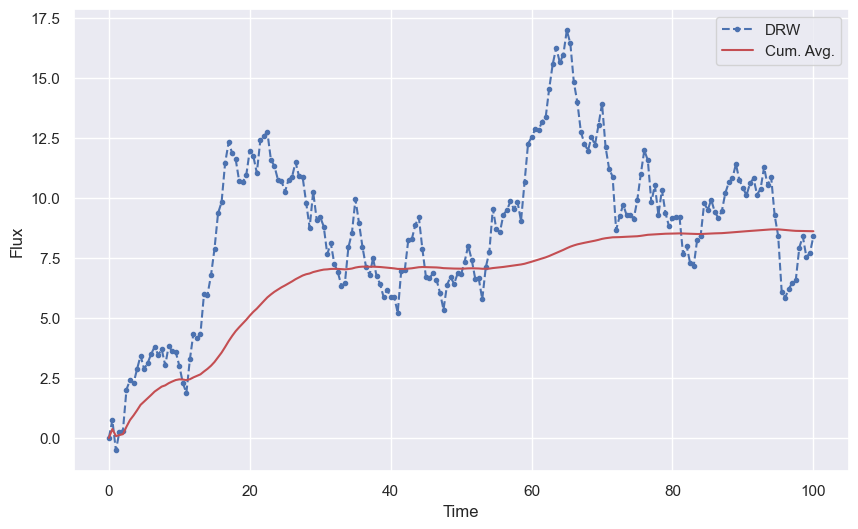

In [87]:
t = np.linspace(0, 100, 201) # time array
params = [10, 1, 10] # tau, sigma, b
drw = drw_step(t, *params)

# plot
plt.figure(figsize=(10, 6))
plt.plot(t, drw, '.--', label=('DRW'))
# cumulative average?
cumavg = np.cumsum(drw)/np.linspace(1, len(drw), len(drw))
plt.plot(t, cumavg, 'r', label='Cum. Avg.')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

In their paper, Kelly et al. describe three different timescales relevant to quasars that they introduce as characteristic timescales and plot with. I'm going to do the same. These are equations (3), (4), and (5) in the paper, describing the light-crossing time, gas-orbiting time, and thermal time for the disk, respectively. I'm just going to be using standard values for quasars: $M_{BH} = 10^8\: M_\odot$, $R = 100\: R_S$, $\alpha=0.01$ for this.

In [88]:
import astropy.units as u
import astropy.constants as c

In [89]:
alpha = 0.01
M_BH = 1e8 * c.M_sun
R_S = lambda M_BH=M_BH: 2*c.G*M_BH/c.c**2
R = 100 * R_S()

t_lc = lambda M=M_BH, R=R: 1.1 * (M/(1e8*c.M_sun)) * (R/(100*R_S(M_BH))) * u.day
t_orb = lambda M=M_BH, R=R: 104 * (M/(1e8*c.M_sun)) * (R/(100*R_S(M_BH)))**(3/2) * u.day
t_th = lambda a=alpha, M=M_BH, R=R: 4.6 * (a/0.01)**-1 * (M/(1e8*c.M_sun)) * (R/(100*R_S(M_BH)))**(3/2) * u.yr

print(f't_lc: {t_lc()}, \nt_orb: {t_orb()}, \nt_th: {t_th().to(u.d):.2f}')

t_lc: 1.1 d, 
t_orb: 104.0 d, 
t_th: 1680.15 d


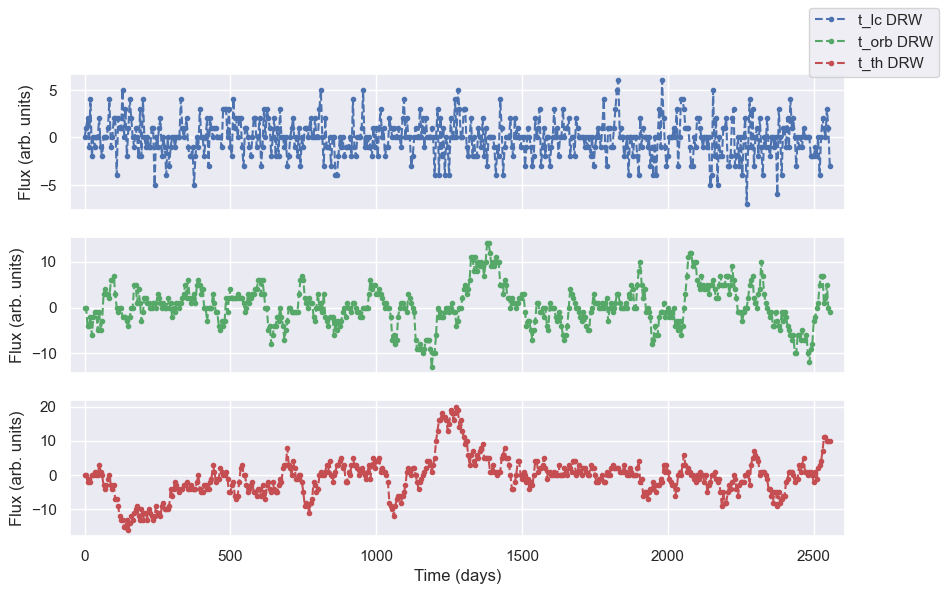

In [92]:
timesteps = np.arange(0, 7*365+1, 5)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 6))
ax[0].plot(timesteps, drw_step(timesteps, t_lc().value, 1., 0.), 'b.--', label=('t_lc DRW'))
ax[1].plot(timesteps, drw_step(timesteps, t_orb().value, 1., 0.), 'g.--', label=('t_orb DRW'))
ax[2].plot(timesteps, drw_step(timesteps, t_th().to(u.d).value, 1., 0.), 'r.--', label=('t_th DRW'))
# [ax[_].legend() for _ in range(len(ax))]
fig.legend()
plt.xlabel('Time (days)')
plt.xlim(np.max(timesteps)-np.max(timesteps)*1.02, np.max(timesteps)*1.02)
[ax[_].set_ylabel('Flux (arb. units)') for _ in range(len(ax))]
plt.show()

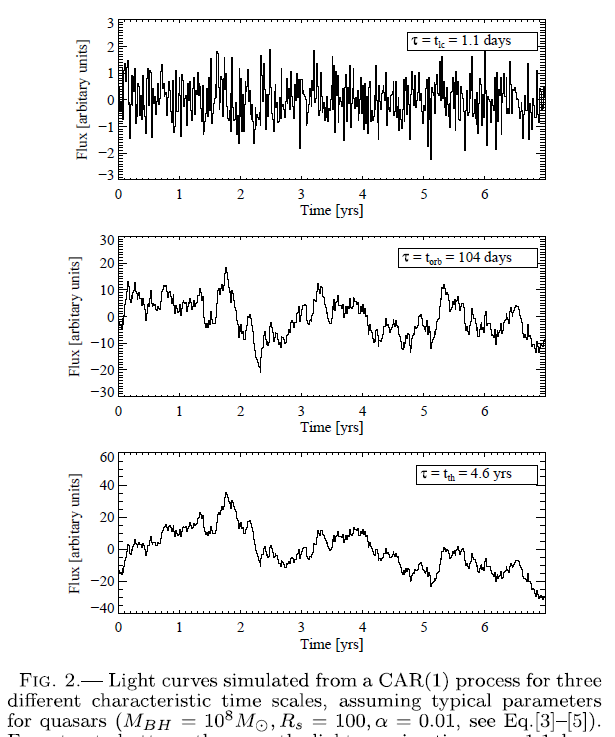

Above is from the Kelly et al. 2009 paper that I am mimicking. They write: *"The increased amount of variation on long time scales with increasing $\tau$ is apparent."* I do not get the same result, for some reason, using their equation (1). Changing the time to be an exponentially decaying term helps.